# Trying CNN 

In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from Network_dropout import *
from TorchMalaria import *

import matplotlib.pyplot as plt
from skimage.transform import resize

torch.set_num_threads(2)

In [2]:
data = DataMalaria("listSmallImg.csv", transform=torchvision.transforms.ToTensor(), TTS = True)

In [3]:
data.trainmode()
batchsize = 200
trainloader = DataLoader(data, batch_size = batchsize, shuffle = True)
len(data)/batchsize

103.34

In [4]:
labelTrain = data.train.iloc[:, 1]
labelTest = data.test.iloc[:, 1]

print("Label ratio for train data: {:2.1f}%".format(sum(labelTrain)/len(labelTrain)*100))
print("Label ratio for test data: {:2.1f}%".format(sum(labelTest)/len(labelTest)*100))

Label ratio for train data: 50.3%
Label ratio for test data: 49.0%


In [5]:
trainIter = iter(trainloader)

batch = next(trainIter)
images, labels = batch
if len(images) < 10:
    # make grid takes tensor as arg
    # tensor : (batchsize, channels, height, width)
    grid = torchvision.utils.make_grid(images)
    fig = plt.figure(figsize=(10, 80))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy())
    plt.show()

In [16]:
data.trainmode()
network = Network()
network.double()
network.load_state_dict(torch.load("NetworkModel_dropout.pt"))
optimizer = optim.Adam(network.parameters(), lr = 0.005)

nEpochs = 10


for epoch in range(nEpochs):
    totalLoss = 0
    totalCorrect = 0
    counter = 0
    t = time.time()
    
    for batch in trainloader:
        images, labels = batch
        
        # forward pass + calculate loss
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        # PyTorch telt alle gradienten op. Daarom moet de gradient gereset worden.
        optimizer.zero_grad()

        # backward propagation + updating weights
        loss.backward()
        optimizer.step()

        totalLoss += loss.item()
        totalCorrect += GetNumCorrect(preds, labels)
        clear_output()
        counter += len(labels)
        print("{}/{}".format(counter, len(data)))
        print("epoch: {}\nTotalCorrect: {}\nTotalLoss: {}\n\nTime: {:3.1f}s\nAccuracy: {}\n\n".format(epoch, totalCorrect, totalLoss, time.time() - t, totalCorrect.item() / counter))


20668/20668
epoch: 9
TotalCorrect: 19779
TotalLoss: 13.312595258182137

Time: 50.2s
Accuracy: 0.9569866460228372




In [17]:
torch.save(network.state_dict(), "NetworkModel_dropout.pt")

In [5]:
network1 = Network()
network1.double()
network1.load_state_dict(torch.load("NetworkModel_dropout.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
data.testmode()
testloader = DataLoader(data, batch_size = batchsize, shuffle = True)

In [9]:
def apply_threshhold(preds):
    avg = np.abs(np.diff(preds.detach().numpy())).mean()
    stdev = np.abs(np.diff(preds.detach().numpy())).std()
    thresh = avg - stdev
    ind = np.abs(np.diff(preds.detach().numpy())) < thresh
    addition = torch.tensor(ind, dtype = torch.float64).squeeze()*thresh
    preds[:, 1] = preds[:, 1] + addition
    return preds

In [10]:
batch = next(iter(testloader))
from sklearn.metrics import confusion_matrix
confmat = np.zeros((2, 2))

counter = 0
totalCorrect = 0 

for batch in testloader:
    images, labels = batch

    # forward pass + calculate loss
    preds = network1(images)
    preds = apply_threshhold(preds)

    confmat += confusion_matrix(labels, preds.argmax(dim = 1).numpy())
    clear_output()
    counter += len(labels)
    totalCorrect += GetNumCorrect(preds, labels)
    
    print("{}/{}".format(counter, len(data)))
    print("{:4.0f}|{:4.0f}\n{:4.0f}|{:4.0f}".format(confmat[0, 0], confmat[0, 1], confmat[1, 0], confmat[1, 1]))
    print("Accuracy: {:2.1f}".format(totalCorrect.item()/counter * 100))

6890/6890
3077| 439
  95|3279
Accuracy: 92.2


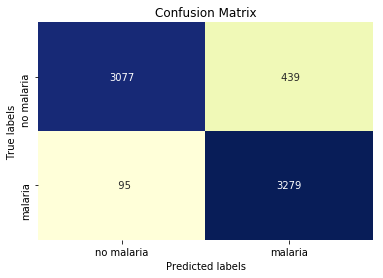

In [11]:
import seaborn as sns
def pretty_confusion_matrix(cm, labels = ["no malaria", "malaria"]):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap="YlGnBu", fmt = "4.0f", cbar = False); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    
pretty_confusion_matrix(confmat)

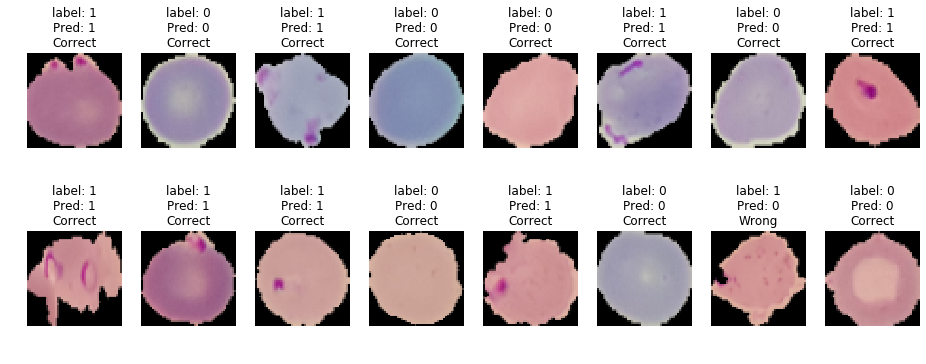

In [23]:
fig, axes = plt.subplots(2, 8, sharey = True)
fig.set_size_inches(16, 6)
ind = np.random.randint(len(data), size = 16)
counter = 0
for rowAx in axes:
    for ax in rowAx:
        ax.axis("off")
        image, label = data[ind[counter]]
        out = network1(image.unsqueeze(0))
        out = apply_threshhold(out)
        pred = out.argmax(dim = 1).numpy()[0]
        data.imshowsingle(ind[counter], ax)
        if label == pred:
            resultText = "Correct"
        else:
            resultText = "Wrong"
        ax.title.set_text("label: {}\nPred: {}\n{}".format(label, pred, resultText))
        
            
        ax.set_xlabel(resultText)
        counter += 1
plt.show()

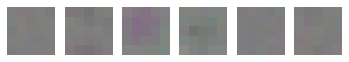

In [14]:
filters = network1.conv1.weight.data.numpy()
filters = (1/(2*3.69201088))*filters + 0.5 #Normalizing the values to [0,1]



num_kernels = num_cols = filters.shape[0]
num_channels = num_rows = filters.shape[1]
#num_rows = 1 + (num_kernels+num_channels) // num_cols

fig, axes = plt.subplots(1, num_cols)
fig.set_size_inches(num_cols, num_rows)
for i in range(num_cols):
    for j in range(num_rows):
        ax = axes[i]
        ax.imshow(filters[i].transpose(2, 1, 0))
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])